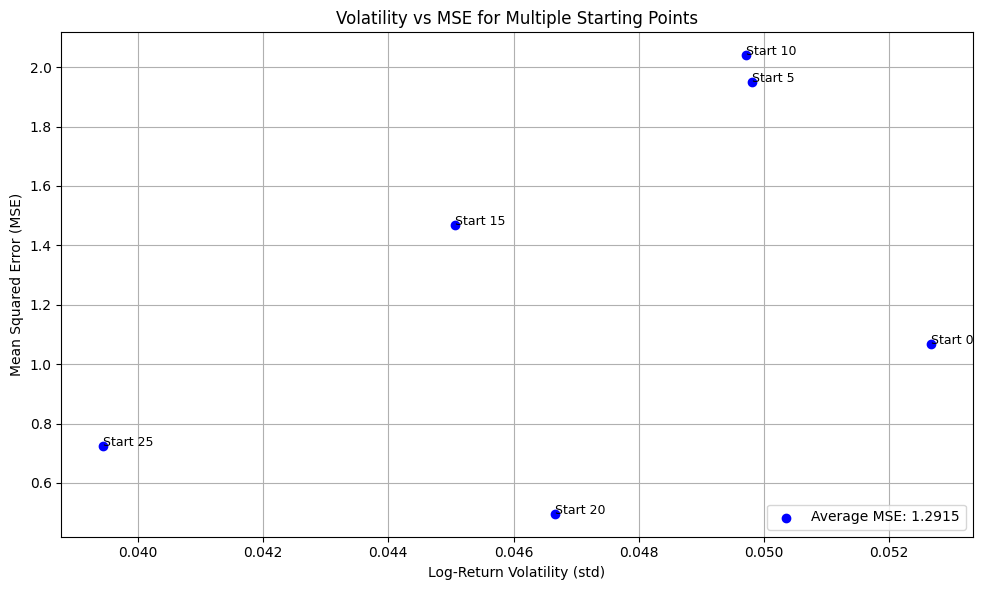

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# Function to create lag features and rolling statistics
def create_lag_features(data, lags):
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = data['Close'].pct_change(lag)  # Percentage change
    data['rolling_mean'] = data['Close'].rolling(window=5).mean()
    data['rolling_std'] = data['Close'].rolling(window=5).std()
    return data

# Function to split the dataset
def split_data(df, training_period, train_ratio=0.8):
    # Create lag features and rolling statistics
    df = create_lag_features(df, training_period)
    df.dropna(inplace=True)  # Remove rows with NaN values

    # Scale features
    feature_scaler = StandardScaler()
    scaled_features = feature_scaler.fit_transform(df.drop(columns=['Close']))
    scaled_data = pd.DataFrame(scaled_features, columns=df.drop(columns=['Close']).columns, index=df.index)
    scaled_data['Close'] = df['Close']  # Keep original target for splitting

    # Scale the target variable
    target_scaler = StandardScaler()
    scaled_data['Close'] = target_scaler.fit_transform(df['Close'].values.reshape(-1, 1)).ravel()

    # Split data
    split_idx = int(len(df) * train_ratio)
    train_data = scaled_data.iloc[:split_idx]
    test_data = scaled_data.iloc[split_idx:]

    # Separate features and targets
    X_train = train_data.drop(columns=['Close'])
    y_train = train_data['Close']
    X_test = test_data.drop(columns=['Close'])
    y_test = test_data['Close']

    return X_train, y_train, X_test, y_test, test_data.index, feature_scaler, target_scaler

# Function to train the XGBoost model
def train_xgboost(X_train, y_train):
    model = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        objective='reg:squarederror',
        random_state=42
    )
    model.fit(X_train, y_train)
    return model
# Function to calculate log-return volatility
def calculate_log_volatility(y_values):
    log_returns = np.log(y_values[1:] / y_values[:-1])  # Logarithmic returns
    return np.std(log_returns)  # Volatility as standard deviation of log returns

# Updated evaluate function with average MSE in the legend
def evaluate_multiple_start_points(model, X_test, y_test, test_index, n_days_to_predict, num_start_points, feature_scaler, target_scaler):
    errors = []
    volatilities = []

    # Select start indices
    start_indices = range(0,30,5)  # Example: 5 starting points, spaced 5 indices apart

    for start_idx in start_indices:
        end_idx = start_idx + n_days_to_predict

        # Ensure the model always gets the past 15 days of data
        context_idx = start_idx - 15
        X_context = X_test.iloc[context_idx:start_idx]  # Past 15 days
        
        X_sub = X_test.iloc[start_idx:end_idx]
        y_true = y_test.iloc[start_idx:end_idx]

        # Predict and invert scaling for the target
        predictions = model.predict(X_sub)
        predictions = target_scaler.inverse_transform(predictions.reshape(-1, 1)).ravel()
        y_true_unscaled = target_scaler.inverse_transform(y_true.values.reshape(-1, 1)).ravel()

        # Calculate MSE
        mse = mean_squared_error(y_true_unscaled, predictions)
        errors.append(mse)

        # Calculate log-return volatility
        log_volatility = calculate_log_volatility(y_true_unscaled)
        volatilities.append(log_volatility)

        # Plot individual predictions
        plt.figure(figsize=(10, 6))
        plt.plot(test_index[start_idx:end_idx], y_true_unscaled, label="True Data", color="green")
        plt.plot(test_index[start_idx:end_idx], predictions, label="Predictions", color="orange")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.title(f"Predictions from Index {start_idx} to {end_idx}")
        plt.legend()
        os.makedirs("../TSLA_pred/xgboost/", exist_ok=True)
        plt.savefig(f"../TSLA_pred/xgboost/start_{start_idx}.png")
        plt.close()

    # Calculate average MSE
    avg_mse = np.mean(errors)

    # Scatter plot: log-return volatility vs MSE
    plt.figure(figsize=(10, 6))
    plt.scatter(volatilities, errors, marker="o", color="blue")
    for i, idx in enumerate(start_indices):
        plt.text(volatilities[i], errors[i], f"Start {idx}", fontsize=9)
    plt.xlabel("Log-Return Volatility (std)")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.title("Volatility vs MSE for Multiple Starting Points")
    plt.grid(True)

    # Add legend with average MSE
    plt.legend([f"Average MSE: {avg_mse:.4f}"], loc="lower right")
    plt.tight_layout()

    # Save the plot
    os.makedirs("../TSLA_pred/xgboost", exist_ok=True)
    plt.savefig("../TSLA_pred/xgboost/log_volatility_vs_mse.png")
    plt.show()



# Main function
def main():
    training_period = 15  # Number of days for lag features
    n_days_to_predict = 15  # Number of days to predict for each starting point
    num_start_points = 15  # Number of unique starting points
    path = "../TSLA.csv"  # Path to your stock data file

    # Load and preprocess data
    headers = ["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]
    df = pd.read_csv(path, names=headers, skiprows=1)
    df.replace("null", np.nan, inplace=True)
    df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]] = df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]].astype(float)
    df.set_index("Date", inplace=True)

    # Split the dataset into training and testing sets
    X_train, y_train, X_test, y_test, test_index, feature_scaler, target_scaler = split_data(df, training_period)

    # Train the XGBoost model
    model = train_xgboost(X_train, y_train)

    # Evaluate predictions for multiple starting points
    evaluate_multiple_start_points(model, X_test, y_test, test_index, n_days_to_predict, num_start_points, feature_scaler, target_scaler)

# Run the main function
if __name__ == "__main__":
    main()


graph/measure of accuracy is a WIP